# Plot IV all curves with average IV curves

IVs overall

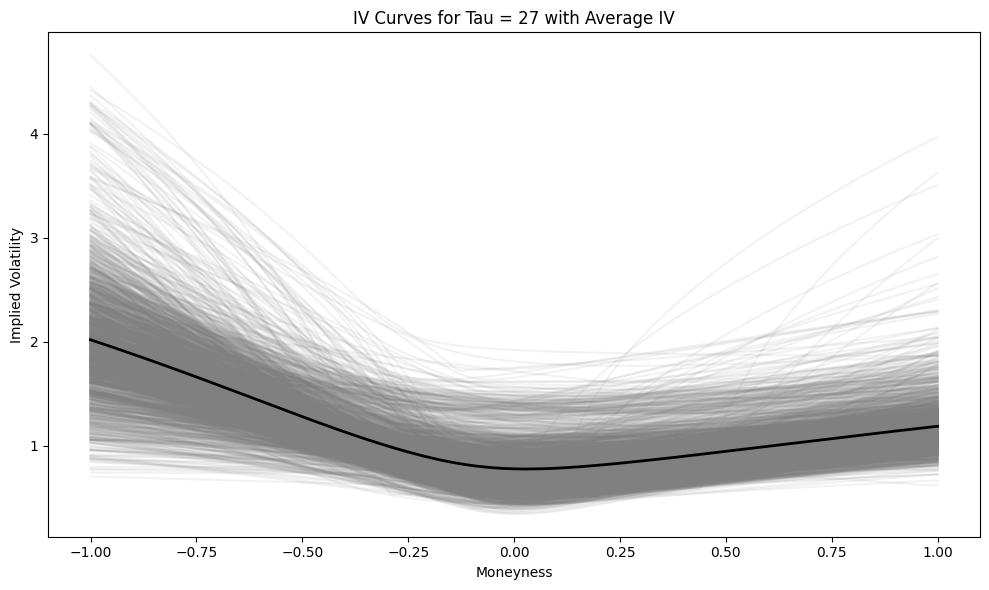

In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory with the interpolated IV files
interpolated_iv_path = "IV/IV_surface_SVI/Tau-independent/unique/moneyness_step_0d01/"
files = sorted(glob.glob(os.path.join(interpolated_iv_path, "interpolated_*_allR2.csv")))
plot_to_save_path = "IV/IV_curve_SVI_average_plot/Tau-independent/unique/moneyness_step_0d01/"
os.makedirs(plot_to_save_path, exist_ok=True)

plt.figure(figsize=(10, 6))

# Lists to store all IV curves and corresponding moneyness values
all_iv_curves = []
common_moneyness = None

for file in files:
    df = pd.read_csv(file)
    # Filter the DataFrame to only include rows where TTM == 27
    df_tau = df[df["TTM"] == 27]
    if df_tau.empty:
        continue
    
    # There should be one row per file with TTM == 27
    row = df_tau.iloc[0]
    
    # Extract IV values by dropping the "Date" and "TTM" columns
    iv_values = row.drop(labels=["Date", "TTM"])
    
    # Convert the remaining column names (assumed moneyness) to floats
    try:
        moneyness = np.array([float(col) for col in iv_values.index])
    except ValueError:
        moneyness = iv_values.index.astype(float)
    
    iv = iv_values.values.astype(float)
    
    # Sort by moneyness in case columns are not in order
    sort_idx = np.argsort(moneyness)
    moneyness = moneyness[sort_idx]
    iv = iv[sort_idx]
    
    # Plot individual IV curve in gray
    date_label = row["Date"]
    plt.plot(moneyness, iv, label=date_label, alpha=0.1, color="gray")
    
    # Store the IV curve for averaging if it doesn't contain NaNs, othersie print the date
    if np.isnan(iv).any():
        print(f"NaN values found in IV curve for {date_label}")
    else:
        all_iv_curves.append(iv)
    if common_moneyness is None:
        common_moneyness = moneyness

# Compute and plot the average IV curve if any curves were found
if all_iv_curves:
    avg_iv = np.nanmean(all_iv_curves, axis=0)
    plt.plot(common_moneyness, avg_iv, color="black", linewidth=2, label="Average IV")

plt.xlabel("Moneyness")
plt.ylabel("Implied Volatility")
plt.title("IV Curves for Tau = 27 with Average IV")
plt.grid(False)
plt.tight_layout()
plt.savefig(os.path.join(plot_to_save_path, "IV_curve_SVI_overall_average_Tau-independent_unique_moneyness_step_0d01_TTM_27.png"))
plt.show()

By each cluster

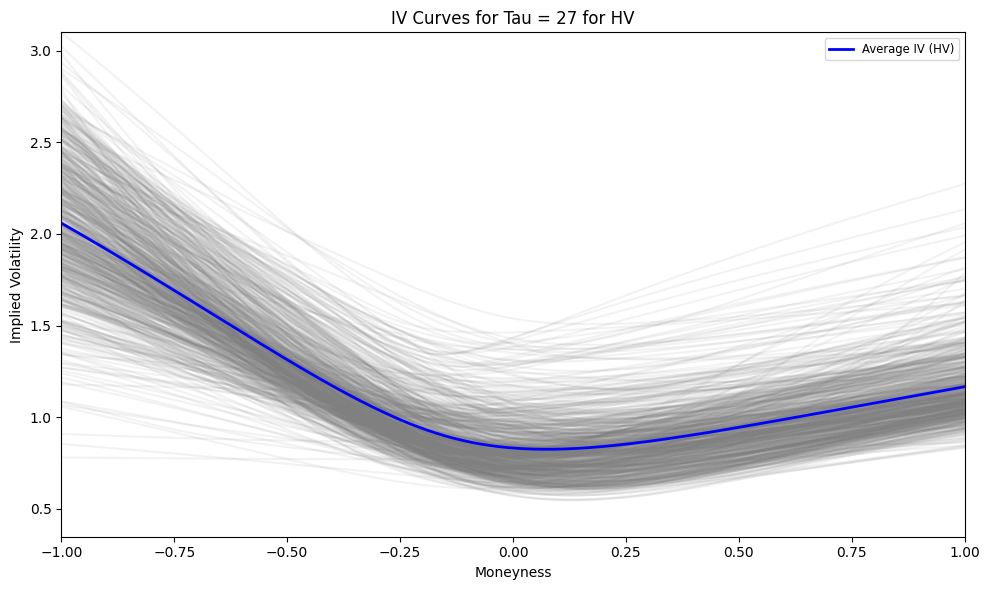

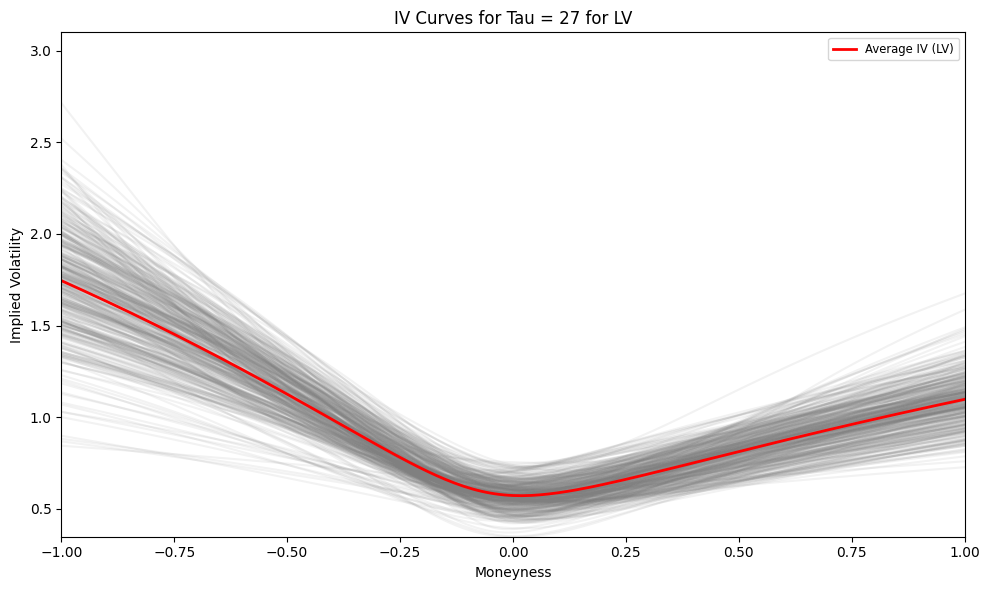

In [6]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load cluster dates
common_dates = pd.read_csv(os.path.join('Clustering', 'Tau-independent', 'unique', 'moneyness_step_0d01', 
                                          'multivariate_clustering_9_27_45', 'common_dates_cluster.csv'))
dates_Q = {
    0: common_dates[common_dates["Cluster"] == 0]["Date"].astype(str).tolist(),
    1: common_dates[common_dates["Cluster"] == 1]["Date"].astype(str).tolist()
}

# Define cluster names: HV for cluster 0 and LV for cluster 1
cluster_names = {0: "HV", 1: "LV"}

# Directory with the interpolated IV files and setup save directory
interpolated_iv_path = "IV/IV_surface_SVI/Tau-independent/unique/moneyness_step_0d01/"
files = sorted(glob.glob(os.path.join(interpolated_iv_path, "interpolated_*_allR2.csv")))
plot_to_save_path = os.path.join("IV", "IV_curve_SVI_average_plot", "Tau-independent", "unique", "moneyness_step_0d01", "multivariate_clustering_9_27_45")
os.makedirs(plot_to_save_path, exist_ok=True)

# Dictionaries to store IV curves and common moneyness for each cluster
cluster_iv_curves = {0: [], 1: []}
cluster_common_moneyness = {0: None, 1: None}

# Loop over each file and process the IV curves for TTM == 27
for file in files:
    df = pd.read_csv(file)
    # Filter the DataFrame for rows with TTM equal to 27
    df_tau = df[df["TTM"] == 27]
    if df_tau.empty:
        continue

    # There should be one row per file with TTM == 27
    row = df_tau.iloc[0]
    date_label = row["Date"]

    # Check which cluster the date belongs to
    if date_label in dates_Q[0]:
        cluster = 0
    elif date_label in dates_Q[1]:
        cluster = 1
    else:
        # Date not in any cluster; skipping.
        continue

    # Extract IV values by dropping non-IV columns ("Date" and "TTM")
    iv_values = row.drop(labels=["Date", "TTM"])

    # Convert column names (assumed moneyness) to floats
    try:
        moneyness = np.array([float(col) for col in iv_values.index])
    except ValueError:
        moneyness = iv_values.index.astype(float)

    iv = iv_values.values.astype(float)

    # Sort by moneyness in case columns are not in order
    sort_idx = np.argsort(moneyness)
    moneyness = moneyness[sort_idx]
    iv = iv[sort_idx]

    # Check if IV curve contains NaN values; if so, print a warning
    if np.isnan(iv).any():
        print(f"NaN values found in IV curve for {date_label}")
    else:
        cluster_iv_curves[cluster].append(iv)

    # Set common moneyness for the cluster if not already set
    if cluster_common_moneyness[cluster] is None:
        cluster_common_moneyness[cluster] = moneyness

# Unify the axis ranges across both clusters
# x-axis from common moneyness arrays, y-axis from all IV values
all_moneyness = []
for cl in [0, 1]:
    if cluster_common_moneyness[cl] is not None:
        all_moneyness.append(cluster_common_moneyness[cl])
if all_moneyness:
    all_moneyness = np.concatenate(all_moneyness)
    x_min, x_max = np.min(all_moneyness), np.max(all_moneyness)
else:
    x_min, x_max = 0, 1  # fallback values

all_iv_values = []
for cl in [0, 1]:
    for iv in cluster_iv_curves[cl]:
        all_iv_values.append(iv)
if all_iv_values:
    all_iv_values = np.concatenate(all_iv_values)
    y_min, y_max = np.min(all_iv_values), np.max(all_iv_values)
else:
    y_min, y_max = 0, 1  # fallback values

# Create separate plots for each cluster using unified axis limits
for cluster in [0, 1]:
    plt.figure(figsize=(10, 6))
    color = "blue" if cluster == 0 else "red"
    name = cluster_names[cluster]
    
    # Plot all individual IV curves for this cluster in light lines
    for iv in cluster_iv_curves[cluster]:
        plt.plot(cluster_common_moneyness[cluster], iv, color="gray", alpha=0.1)
    
    # Compute and plot the average IV curve for this cluster if available
    if cluster_iv_curves[cluster]:
        avg_iv = np.nanmean(cluster_iv_curves[cluster], axis=0)
        plt.plot(cluster_common_moneyness[cluster], avg_iv, color=color, linewidth=2, label=f"Average IV ({name})")

    plt.xlabel("Moneyness")
    plt.ylabel("Implied Volatility")
    plt.title(f"IV Curves for Tau = 27 for {name}")
    plt.grid(False)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(loc="best", fontsize="small")
    plt.tight_layout()
    
    # Save the plot for this cluster
    output_filename = os.path.join(plot_to_save_path, 
        f"IV_curve_SVI_{name}_average_Tau-independent_unique_moneyness_step_0d01_TTM_27.png")
    plt.savefig(output_filename)
    plt.show()